## Motivation
When conducting nuisance regression, we want to be careful about choosing our regressors as we can add noise back into the residual timeseries, which will overall decrease the integrity of our data.

To simulate this scenerio, I will take a straight line (representing our current bold series) and series of random numbers (representing a nuisance confound that does not help our data).

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import numpy as np
from scipy.stats import ttest_ind

In [6]:
# perfect signal (nicely denoised BOLD)
y = np.linspace(0,199,200)
# random noise (bad regressor)
x = np.random.rand(200)


In [7]:

ts_dict = {'y': y, 'x': x}

# regression 
model = smf.ols(formula='y ~ x', data=ts_dict)
result = model.fit()
residual = result.resid

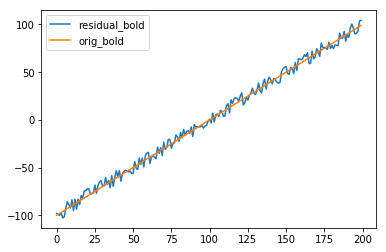

In [8]:
plt.plot(residual, label='residual_bold')
plt.plot(y-100, label='orig_bold')
plt.legend()

### Here is a demonstration of more "structured noise"

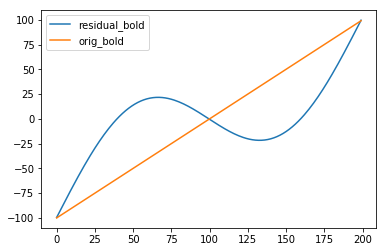

In [5]:
# sin wave (imagine this nuisance confound was derived from the original bold series)
x_struct = np.sin(np.linspace(-np.pi, np.pi, 200))
# y still represents the denoised bold series

ts_dict2 = {'y': y, 'x': x_struct}

# regression 
model2 = smf.ols(formula='y ~ x', data=ts_dict2)
result2 = model2.fit()
residual2 = result2.resid

plt.plot(residual2, label='residual_bold')
plt.plot(y-100, label='orig_bold')
plt.legend()

### Now let's see if we can systematically reduce the correlation between 2 timeseries using a common regressor.

In [109]:
# bold series 1 (or say voxel1)
y1 = np.random.rand(200)
# bold series 2 (or say voxel2)
y2 = np.random.rand(200)
# the noisey regressor pulled from non-denoised bold
x_noise = np.sin(np.linspace(-np.pi*10, np.pi*10, 200))

# for using these variables in ols
model_terms = {'y1': y1, 'y2': y2, 'x': x_noise}

# regressing the influence of the noisy regressor from voxel1
model1 = smf.ols(formula='y1 ~ x', data=model_terms)
result1 = model1.fit()
residual1 = result1.resid

# regressing the influence of the noisy regressor from voxel2
model2 = smf.ols(formula='y2 ~ x', data=model_terms)
result2 = model2.fit()
residual2 = result2.resid

In [110]:
print('baseline correlation coefficients between series')
display(np.corrcoef(y1,y2))
print('correlation coefficients of residuals')
display(np.corrcoef(residual1, residual2))

baseline correlation coefficients between series


array([[1.        , 0.06744444],
       [0.06744444, 1.        ]])

correlation coefficients of residuals


array([[1.        , 0.06774485],
       [0.06774485, 1.        ]])

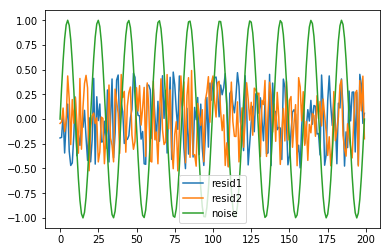

In [111]:
plt.plot(residual1, label='resid1')
plt.plot(residual2, label='resid2')
plt.plot(x_noise, label='noise')
plt.legend()

This actually suggests that structured noise does not have a reliable impact on the correlation between two (random) timeseries (sometimes increases, sometimes decreases).

### Let's test more rigorously

In [95]:
baseline_coef = []
residual_coef = []
sanity_check = []
x_noise = np.sin(np.linspace(-np.pi*10, np.pi*10, 200))
# x_noise = np.random.rand(200)
model_terms = {'y1': y1, 'y2': y2, 'x': x_noise}
for _ in range(10000):
    y1 = np.random.rand(200)
    y2 = np.random.rand(200)
    
   
    
    baseline_coef.append(np.corrcoef(y1,y2)[0,1])
    
    # regression 
    model1 = smf.ols(formula='y1 ~ x', data=model_terms)
    result1 = model1.fit()
    residual1 = result1.resid

    model2 = smf.ols(formula='y2 ~ x', data=model_terms)
    result2 = model2.fit()
    residual2 = result2.resid
    residual_coef.append(np.corrcoef(residual1, residual2)[0,1])
    
    sanity_check.append(np.corrcoef(np.random.rand(200), np.random.rand(200))[0,1])
    

In [112]:

tstat, p_value = ttest_ind(baseline_coef, residual_coef)
sanity_tstat, sanity_p_value = ttest_ind(baseline_coef, sanity_check)
print('baseline average correlation')
display(sum(baseline_coef)/len(baseline_coef))
print('residual average correlation')
display(sum(residual_coef)/len(residual_coef))
print('sanity check average correlation')
display(sum(sanity_check)/len(sanity_check))
print('tstat for difference between baseline and residuals')
display(tstat)
print('p value for difference between baseline and residuals')
display(p_value)
print('tstat for difference between baseline and sanity')
display(sanity_tstat)
print('p value for difference between baseline and sanity')
display(sanity_p_value)

baseline average correlation


1.8668478568973385e-05

residual average correlation


-0.04424029862071116

sanity check average correlation


0.00013041986465165656

tstat for difference between baseline and residuals


63.0110707108941

p value for difference between baseline and residuals


0.0

tstat for difference between baseline and sanity


-0.11203871798658496

p value for difference between baseline and sanity


0.9107938317830552

Now it looks like the correlation between between residuals is systematically decreased because of the sin wave noise confound. I don't know why sometimes the correlation is increased as a result of regression, but on average there is decreased correlation between voxels.

### Conclusion?
The residual indicates the nuisance regressor adds "structured" noise to the data (which can induce artificial correlations/anti-correlations), so this suggests we have to be careful with selection of regressors?